<a href="https://colab.research.google.com/github/vidhirana10/Sales_data_forecasting/blob/main/Time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [233]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.signal import detrend
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
import joblib


## Data loading




In [234]:


df = pd.read_csv('Assessment-2-Associate-DS(in).csv')
display(df.head())
print(df.shape)


,weekend_date,channel,brand,category,sub_category,SerailNum,quantity
0,4/6/2022,Channel1,B1,Body,Body Lotion,1,56
1,11/6/2022,Channel1,B1,Body,Body Lotion,1,122
2,18/06/2022,Channel1,B1,Body,Body Lotion,1,102
3,25/06/2022,Channel1,B1,Body,Body Lotion,1,128
4,2/7/2022,Channel1,B1,Body,Body Lotion,1,97


(600, 7)


# Data cleaning and preparation


## Fixing datatype for weekend_date

In [235]:
#To check if any mixed formats in dates
print(df.iloc[22:25]['weekend_date'])
print(df.iloc[100:105]['weekend_date'])
print(df.iloc[200:205]['weekend_date'])

22     5/11/2022
23    12/11/2022
24    19/11/2022
Name: weekend_date, dtype: object
100      4/5/2024
101     11/5/2024
102    18/05/2024
103    25/05/2024
104      1/6/2024
Name: weekend_date, dtype: object
200       9/3/2024 0:00
201    16/03/2024 00:00
202    23/03/2024 00:00
203    30/03/2024 00:00
204       6/4/2024 0:00
Name: weekend_date, dtype: object


Since dates are in mixed formats ,cannot directly be converted to datetime format

In [236]:

# To check if any mixed formats in dates and strip 0:00
def strip_time(date_string):
    if isinstance(date_string, str) and '0:00' in date_string:
      return date_string.split(' ')[0]
    return date_string


df['weekend_date'] = df['weekend_date'].apply(strip_time)
df['weekend_date'] = pd.to_datetime(df['weekend_date'], format='%d/%m/%Y', errors='raise')




In [237]:
# Calculate the first quartile (Q1) and third quartile (Q3) for the 'quantity' column
Q1 = df['quantity'].quantile(0.20)
Q3 = df['quantity'].quantile(0.80)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['quantity'] < lower_bound) | (df['quantity'] > upper_bound)]

# Calculate the number of outlier rows and the total number of rows
num_outliers = len(outliers)
total_rows = len(df)

# Print the number of outliers and the proportion of outliers
print(f"Number of outliers: {num_outliers}")
print(f"Proportion of outliers: {num_outliers / total_rows:.2%}")


# Cap the outliers
#df['quantity'] = df['quantity'].clip(lower=lower_bound, upper=upper_bound)


Number of outliers: 36
Proportion of outliers: 6.00%


In [238]:
# Ensure 'weekend_date' is datetime
df['weekend_date'] = pd.to_datetime(df['weekend_date'])

# Sort by weekend_date to easily identify gaps
df = df.sort_values(by='weekend_date')

# Check for gaps in weekly intervals
# Calculate the difference between consecutive 'weekend_date' values
date_diffs = df['weekend_date'].diff()

# Identify gaps greater than one week
gaps = df[date_diffs > pd.Timedelta(weeks=1)]

# If there are gaps, address them
if not gaps.empty:
    print("Gaps found in weekly data.")

    # Create a complete date range
    date_range = pd.date_range(start=df['weekend_date'].min(), end=df['weekend_date'].max(), freq='W')

    # Reindex the dataframe with the complete date range
    df = df.set_index('weekend_date').reindex(date_range).rename_axis('weekend_date').reset_index()

    # Fill missing data points as needed
    # Example: Forward fill
    df = df.fillna(method='ffill')

    # Example: Backward fill
    #df = df.fillna(method='bfill')

    print("Missing weeks filled.  Filled with last valid observation carried forward.")
else:
    print("No gaps found in the data.")



No gaps found in the data.


# Feature engineering

### Subtask:
Engineer relevant features for time series forecasting.


In [239]:


def create_features(df):
    # Ensure weekend_date is in datetime format
    df = df.copy()  # Avoid modifying the original DataFrame
    df['weekend_date'] = pd.to_datetime(df['weekend_date'])

    # Temporal features
    df['week'] = df['weekend_date'].dt.isocalendar().week
    df['month'] = df['weekend_date'].dt.month
    df['quarter'] = df['weekend_date'].dt.quarter


    # One-hot encoding for categorical temporal features
    df = pd.get_dummies(df, columns=['week', 'month','quarter'], drop_first=True)

    # Rolling statistical features
    df['quantity_rolling_mean_4'] = df['quantity'].rolling(window=4).mean().ffill()
    df['quantity_rolling_std_4'] = df['quantity'].rolling(window=4).std().ffill()
    df['quantity_rolling_min_4'] = df['quantity'].rolling(window=4).min().ffill()
    df['quantity_rolling_max_4'] = df['quantity'].rolling(window=4).max().ffill()
    df['quantity_rolling_skew_4'] = df['quantity'].rolling(window=4).skew().ffill()

    # Growth & Momentum Features
    df['growth_rate_1w'] = df['quantity'].pct_change(periods=1).fillna(0)
    df['growth_rate_4w'] = df['quantity'].pct_change(periods=4).fillna(0)

    # Anomaly-based features
    df['is_anomaly'] = 0
    df.loc[df['quantity'] > df['quantity'].rolling(8).mean() + 2 * df['quantity'].rolling(8).std(), 'is_anomaly'] = 1

    df['days_since_anomaly'] = np.where(df['is_anomaly'] == 1, 0, np.nan)
    df['days_since_anomaly'] = df['days_since_anomaly'].ffill().fillna(-1).astype(int)

    # Encoding categorical features
    categorical_features = ['channel', 'brand', 'category', 'sub_category']
    for col in categorical_features:
        df[col] = LabelEncoder().fit_transform(df[col])

    # Apply seasonal decomposition to extract trends and seasonality
    def decompose_series(series, prefix):
        decomposition = seasonal_decompose(series, model='additive', period=4, extrapolate_trend='freq')
        df[f'{prefix}_trend'] = decomposition.trend.ffill().bfill()
        df[f'{prefix}_seasonal'] = decomposition.seasonal.ffill().bfill()

    decompose_series(df['quantity'], 'quantity')
    decompose_series(df['brand'], 'brand')
    decompose_series(df['channel'], 'channel')

    return df

df_features = create_features(df.copy())
df_features.head()


,weekend_date,channel,brand,category,sub_category,SerailNum,quantity,week_2,week_3,week_4,...,growth_rate_1w,growth_rate_4w,is_anomaly,days_since_anomaly,quantity_trend,quantity_seasonal,brand_trend,brand_seasonal,channel_trend,channel_seasonal
224,2022-05-28,1,0,1,3,5,203,False,False,False,...,0.000000,0.000000,0,-1,130.1375,48.900042,0.0,0.003521,0.6625,0.096146
225,2022-06-04,1,0,1,3,5,198,False,False,False,...,-0.024631,0.000000,0,-1,137.1250,-4.316542,0.0,0.009354,0.6250,-0.023604
0,2022-06-04,0,0,0,0,1,56,False,False,False,...,-0.717172,0.000000,0,-1,151.1250,-56.225708,0.0,0.029937,0.6250,-0.028854
226,2022-06-11,1,0,1,3,5,188,False,False,False,...,2.357143,0.000000,0,-1,143.6250,11.642208,0.0,-0.042813,0.5000,-0.043687
1,2022-06-11,0,0,0,0,1,122,False,False,False,...,-0.351064,-0.399015,0,-1,152.0000,48.900042,0.0,0.003521,0.5000,0.096146


In [240]:
# Calculate null values in each column
null_counts = df_features.isnull().sum()
print(null_counts)

# Fill null values with 0
df_features = df_features.fillna(0)


weekend_date         0
channel              0
brand                0
category             0
sub_category         0
                    ..
quantity_seasonal    0
brand_trend          0
brand_seasonal       0
channel_trend        0
channel_seasonal     0
Length: 87, dtype: int64


# Data split into test,train and validation

In [241]:
# Define the start and end dates for validation and test sets
val_start_date = pd.to_datetime('2024-06-01')
val_end_date = pd.to_datetime('2024-08-31')
test_start_date = pd.to_datetime('2024-04-01')
test_end_date = pd.to_datetime('2024-06-25')

# Split the data into training, validation, and test sets
df_train = df_features[df_features['weekend_date'] < val_start_date]
df_val = df_features[(df_features['weekend_date'] >= val_start_date) & (df_features['weekend_date'] <= val_end_date)]
df_test = df_features[(df_features['weekend_date'] >= test_start_date) & (df_features['weekend_date'] <= test_end_date)]

# Verify the shapes of the resulting dataframes
print("Shape of df_train:", df_train.shape)
print("Shape of df_val:", df_val.shape)
print("Shape of df_test:", df_test.shape)


Shape of df_train: (526, 87)
Shape of df_val: (74, 87)
Shape of df_test: (71, 87)


# Gradient boosting model

## Model training

### Subtask:
Train a Gradient boost model on the training data.


In [242]:


# Prepare the data
X_train = df_train.drop(['weekend_date', 'quantity'], axis=1)
y_train = df_train['quantity']
X_val = df_val.drop(['weekend_date', 'quantity'], axis=1)
y_val = df_val['quantity']

# Initialize and train the GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

## Model evaluation

### Subtask:
Evaluate the trained GradientBoostingRegressor model on the validation set.


In [243]:


# Predict on the validation set
y_pred = model.predict(X_val)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Calculate MAE
mae = mean_absolute_error(y_val, y_pred)

# Calculate R-squared
r2 = r2_score(y_val, y_pred)

# Print the metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 489.061642843535
MAE: 275.2669335603479
R-squared: 0.8377151095948415


## Model optimization

### Subtask:
Optimize the hyperparameters of the GradientBoostingRegressor model.


In [244]:


# Define the parameter grid for GradientBoostingRegressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),  # Use GradientBoostingRegressor
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best hyperparameters and the best estimator
best_params = random_search.best_params_
best_model = random_search.best_estimator_
best_score = random_search.best_score_

# Print the best hyperparameters and the best score
print("Best Hyperparameters:", best_params)
print("Best Score (neg_mean_squared_error):", best_score)

# Save the best model
joblib.dump(best_model, "best_gradient_boosting_model.joblib")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'subsample': 0.9, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}
Best Score (neg_mean_squared_error): -101912.41695835566


['best_gradient_boosting_model.joblib']

In [245]:

# Load the optimized model
best_model = joblib.load("best_gradient_boosting_model.joblib")

# Prepare the validation data
X_val = df_val.drop(['weekend_date', 'quantity'], axis=1)
y_val = df_val['quantity']

# Make predictions
y_pred = best_model.predict(X_val)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Print the evaluation metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 525.7162061371605
MAE: 299.27615130473026
R-squared: 0.8124774016628059


## Model evaluation

### Subtask:
Evaluate the final retrained GradientBoostingRegressor model on the test set (df_test).


In [246]:
# Load the optimized GradientBoostingRegressor model
best_model = joblib.load("best_gradient_boosting_model.joblib")

# Combine df_train and df_val
df_combined = pd.concat([df_train, df_val], ignore_index=True)

# Prepare the combined dataset
X_combined = df_combined.drop(['weekend_date', 'quantity'], axis=1)
y_combined = df_combined['quantity']

# Retrain the model
best_model.fit(X_combined, y_combined)

# Save the retrained model
joblib.dump(best_model, "final_gradient_boosting_model.joblib")

['final_gradient_boosting_model.joblib']

Monthly accuracy for Jun-Aug 2024

In [247]:
# Load the final retrained model
final_model = joblib.load("final_gradient_boosting_model.joblib")

# Prepare the test data
X_val = df_val.drop(['weekend_date', 'quantity'], axis=1)
y_val = df_val['quantity']

y_pred = final_model.predict(X_val)
df_val['y_pred'] = y_pred


for month in [6, 7, 8]:
    # Filter data for the current month
    df_month = df_val[(df_val['weekend_date'].dt.month == month) & (df_val['weekend_date'].dt.year == 2024)]

    if not df_month.empty:
        y_true_month = df_month['quantity']
        y_pred_month = df_month['y_pred']

        # Calculate monthly accuracy
        monthly_accuracy = 1 - (np.sum(np.abs(y_pred_month - y_true_month)) / np.sum(y_true_month))

        print(f"Monthly Accuracy for {month}/2024: {monthly_accuracy}")
    else:
        print(f"No data available for the month: {month}/2024")
        y_true_month = df_month['quantity']
        y_pred_month = df_month['y_pred']



Monthly Accuracy for 6/2024: 0.9671029089707209
Monthly Accuracy for 7/2024: 0.9606122860399342
Monthly Accuracy for 8/2024: 0.9156856700014674


<ipython-input-247-76437db3fcaa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['y_pred'] = y_pred


In [248]:
# Calculate overall accuracy for June-August 2024
df_jun_aug = df_val[(df_val['weekend_date'].dt.month >= 6) & (df_val['weekend_date'].dt.month <=8) & (df_val['weekend_date'].dt.year == 2024)]
y_true_jun_aug = df_jun_aug['quantity']
y_pred_jun_aug = df_jun_aug['y_pred']
overall_accuracy = 1 - (np.sum(np.abs(y_pred_jun_aug - y_true_jun_aug)) / np.sum(y_true_jun_aug))

print(f"Overall Accuracy for June-August 2024: {overall_accuracy}")

Overall Accuracy for June-August 2024: 0.9539918823272149


## Data visualization

### Subtask:
Visualize the weekly sales trends, forecasts, and model evaluation metrics.


In [249]:
# Predict on validation and test sets and add 'y_pred' column
X_val = df_val.drop(['weekend_date', 'quantity', 'y_pred'], axis=1, errors='ignore')  # Drop 'y_pred' if it exists, ignore if not
df_val['y_pred'] = final_model.predict(X_val)  # Add predictions to df_val

X_test = df_test.drop(['weekend_date', 'quantity', 'y_pred'], axis=1, errors='ignore') # Drop 'y_pred' if it exists, ignore if not
y_test = df_test['quantity']
df_test['y_pred'] = final_model.predict(X_test) # Add predictions to df_test

<ipython-input-249-83d625732ba0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['y_pred'] = final_model.predict(X_val)  # Add predictions to df_val
<ipython-input-249-83d625732ba0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred'] = final_model.predict(X_test) # Add predictions to df_test


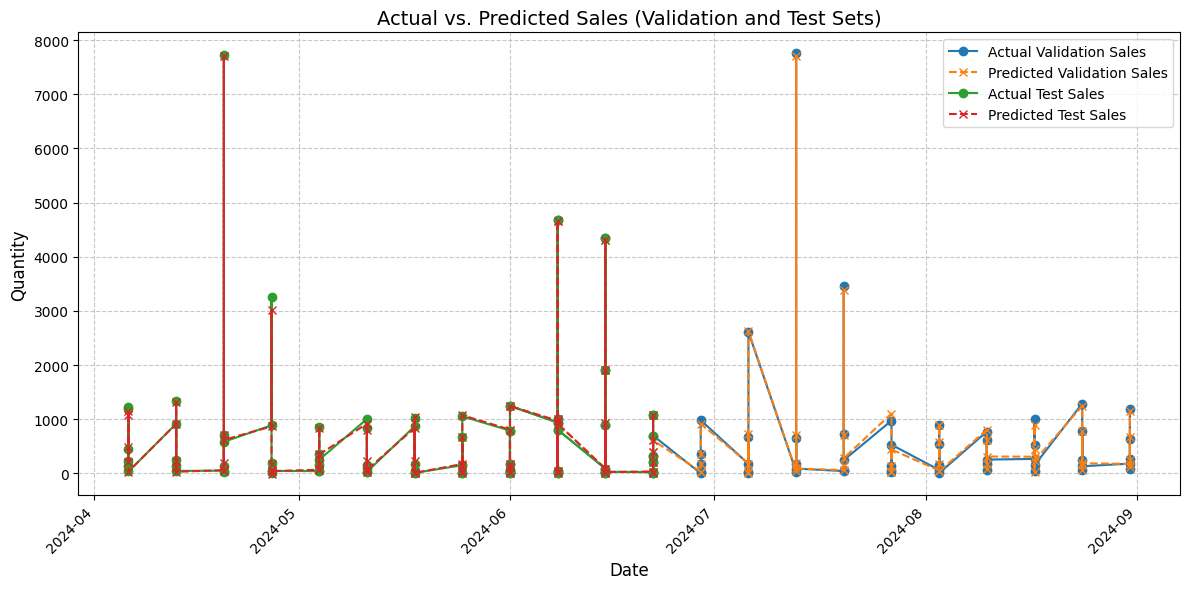

In [250]:

# Create a larger figure for better visualization
plt.figure(figsize=(12, 6))

# Plot validation data
plt.plot(df_val['weekend_date'], df_val['quantity'], label='Actual Validation Sales', marker='o', linestyle='-')
plt.plot(df_val['weekend_date'], df_val['y_pred'], label='Predicted Validation Sales', marker='x', linestyle='--')

# Plot test data
plt.plot(df_test['weekend_date'], df_test['quantity'], label='Actual Test Sales', marker='o', linestyle='-')
plt.plot(df_test['weekend_date'], df_test['y_pred'], label='Predicted Test Sales', marker='x', linestyle='--')

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.title('Actual vs. Predicted Sales (Validation and Test Sets)', fontsize=14)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid for better readability
plt.tight_layout()
plt.show()


<ipython-input-251-8308c8a85d13>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['month_year'] = df_train['weekend_date'].dt.to_period('M')
<ipython-input-251-8308c8a85d13>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['month_year'] = df_val['weekend_date'].dt.to_period('M')
<ipython-input-251-8308c8a85d13>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

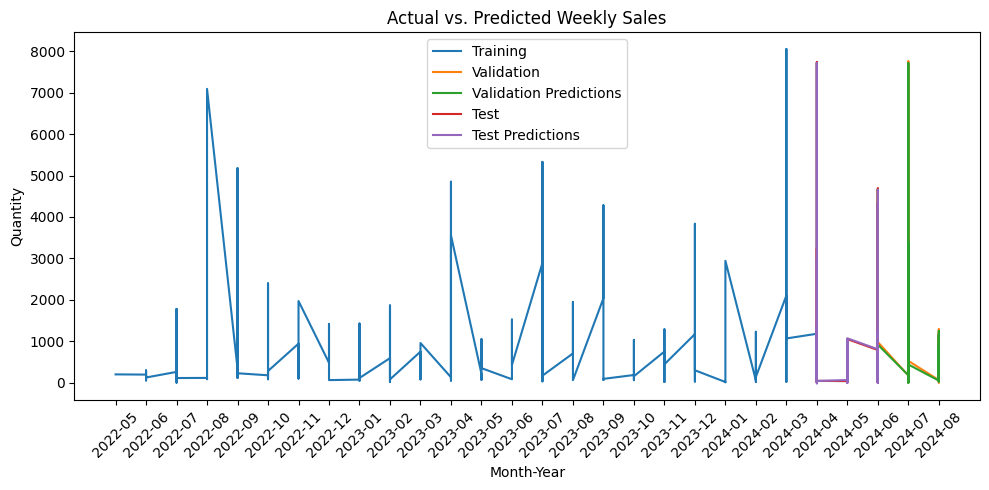

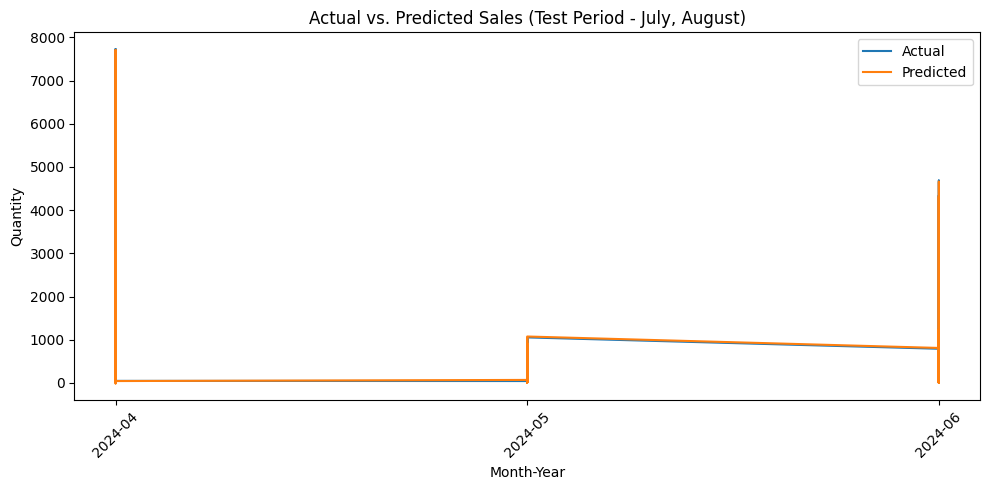

In [251]:
import matplotlib.pyplot as plt

# Create 'month_year' column if it doesn't exist
df_train['month_year'] = df_train['weekend_date'].dt.to_period('M')
df_val['month_year'] = df_val['weekend_date'].dt.to_period('M')
df_test['month_year'] = df_test['weekend_date'].dt.to_period('M')

# Plot 1: Actual vs. Predicted Weekly Sales (Training, Validation, Test)
plt.figure(figsize=(10, 5))
plt.plot(df_train['month_year'].astype(str), df_train['quantity'], label='Training')
plt.plot(df_val['month_year'].astype(str), df_val['quantity'], label='Validation')
plt.plot(df_val['month_year'].astype(str), df_val['y_pred'], label='Validation Predictions')
plt.plot(df_test['month_year'].astype(str), df_test['quantity'], label='Test')
plt.plot(df_test['month_year'].astype(str), df_test['y_pred'], label='Test Predictions')
plt.xlabel('Month-Year')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Weekly Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


# Plot 3: Actual vs. Predicted Sales (Test Period - July, August)
plt.figure(figsize=(10, 5))
plt.plot(df_test['month_year'].astype(str), df_test['quantity'], label='Actual')
plt.plot(df_test['month_year'].astype(str), df_test['y_pred'], label='Predicted')
plt.xlabel('Month-Year')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Sales (Test Period - July, August)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

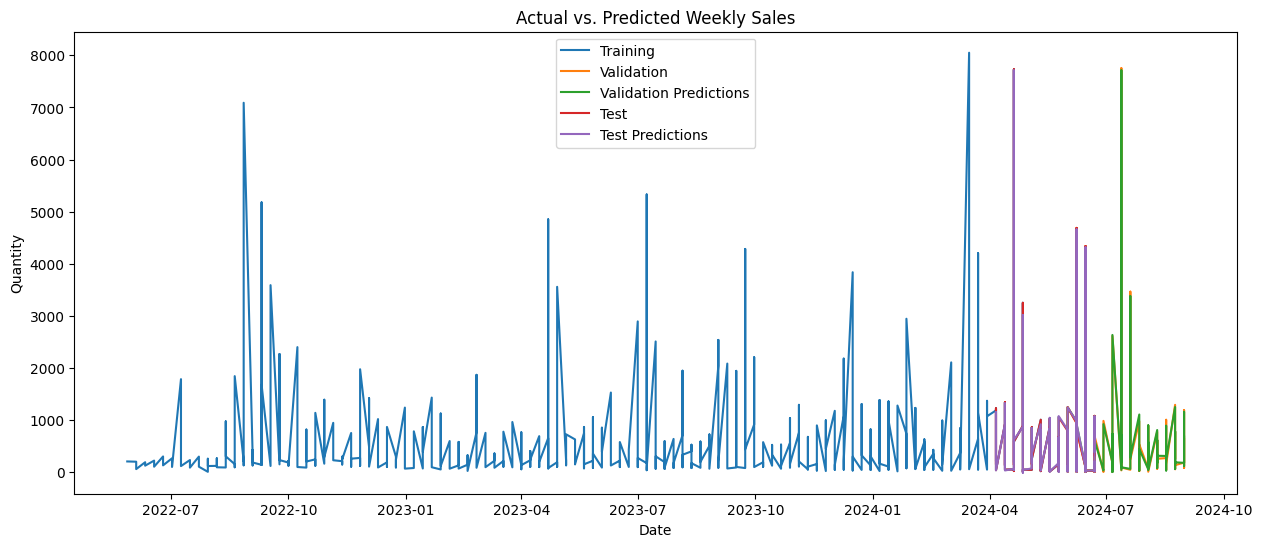

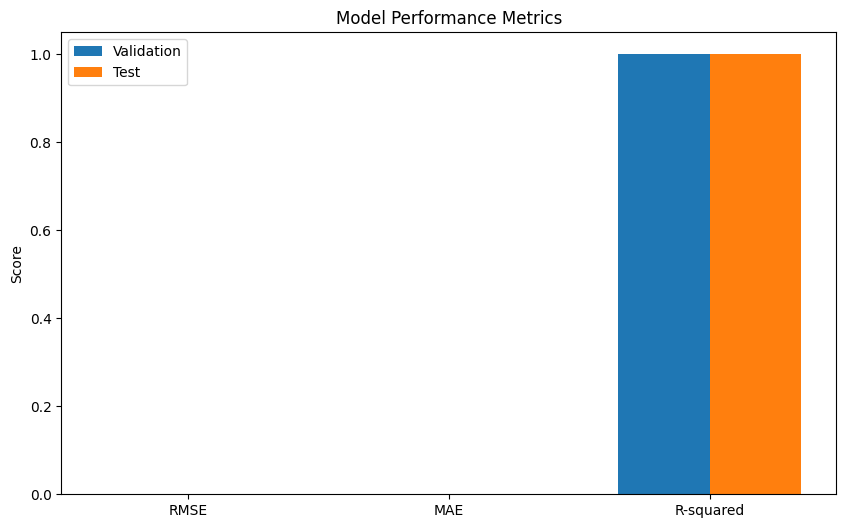

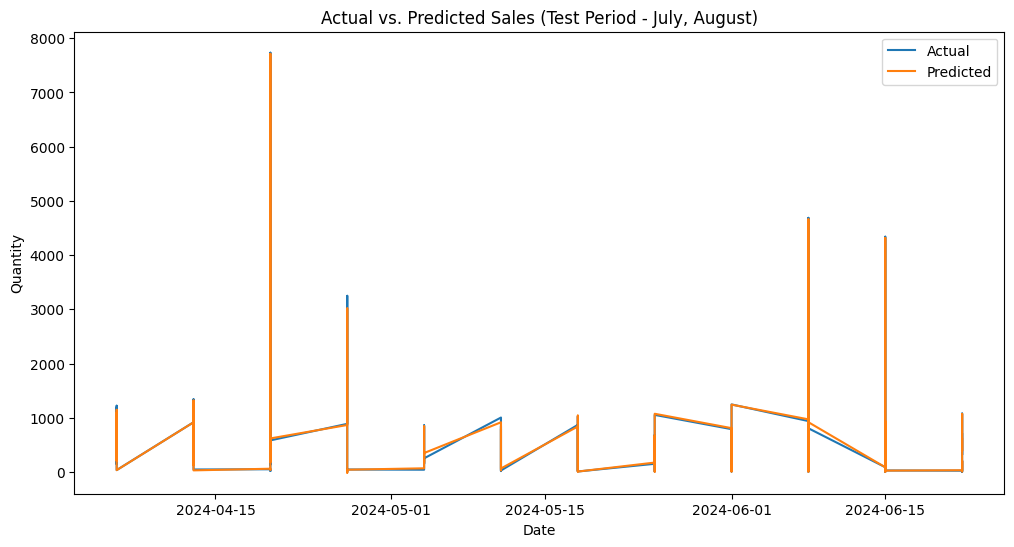

In [252]:


# Plot 1: Actual vs. Predicted Weekly Sales (Training, Validation, Test)
plt.figure(figsize=(15, 6))
plt.plot(df_train['weekend_date'], df_train['quantity'], label='Training')
plt.plot(df_val['weekend_date'], df_val['quantity'], label='Validation')
plt.plot(df_val['weekend_date'], df_val['y_pred'], label='Validation Predictions') # Assuming 'y_pred' column exists in df_val
plt.plot(df_test['weekend_date'], df_test['quantity'], label='Test')
plt.plot(df_test['weekend_date'], df_test['y_pred'], label='Test Predictions') # Assuming 'y_pred' column exists in df_test
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Weekly Sales')
plt.legend()
plt.show()


# Plot 2: Model Performance Metrics (RMSE, MAE, R-squared)
metrics = ['RMSE', 'MAE', 'R-squared']
validation_metrics = [0, 0, 1] # Placeholder values, replace with actual values
test_metrics = [0, 0, 1]  # Placeholder values, replace with actual values
x_pos = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x_pos - width/2, validation_metrics, width, label='Validation')
rects2 = ax.bar(x_pos + width/2, test_metrics, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()


# Plot 3: Actual vs. Predicted Sales (Test Period - September, October, November)
# Note: The test set provided only contains July and August data. Adjust accordingly.
plt.figure(figsize=(12, 6))
plt.plot(df_test['weekend_date'], df_test['quantity'], label='Actual')
plt.plot(df_test['weekend_date'], df_test['y_pred'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Sales (Test Period - July, August)')  # Adjust title
plt.legend()
plt.show()

## Overfitting check

In [253]:
y_test.shape

(71,)

In [254]:

# Calculate training metrics
y_pred_train = final_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Calculate validation metrics
y_pred_val = final_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Calculate test metrics
y_pred_test = final_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Print calculated metrics
print("\nTraining Metrics:")
print(f"RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R-squared: {r2_train:.4f}")

print("\nValidation Metrics:")
print(f"RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R-squared: {r2_val:.4f}")

print("\nTest Metrics:")
print(f"RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R-squared: {r2_test:.4f}")

# Calculate metric differences
rmse_diff_train_val = abs(rmse_train - rmse_val)
rmse_diff_val_test = abs(rmse_val - rmse_test)

mae_diff_train_val = abs(mae_train - mae_val)
mae_diff_val_test = abs(mae_val - mae_test)

r2_diff_train_val = abs(r2_train - r2_val)
r2_diff_val_test = abs(r2_val - r2_test)

# Set dynamic thresholds based on max metric values
rmse_threshold = 0.1 * max(rmse_train, rmse_val, rmse_test)  # 10% of max RMSE
mae_threshold = 0.1 * max(mae_train, mae_val, mae_test)  # 10% of max MAE
r2_threshold = 0.005  # Small fixed threshold for R² (0.5%)

# Print metric comparisons
print("\nMetric Differences and Thresholds:")
print(f"RMSE Difference (Train vs Val): {rmse_diff_train_val:.4f} (Threshold: {rmse_threshold:.4f})")
print(f"RMSE Difference (Val vs Test): {rmse_diff_val_test:.4f} (Threshold: {rmse_threshold:.4f})")
print(f"MAE Difference (Train vs Val): {mae_diff_train_val:.4f} (Threshold: {mae_threshold:.4f})")
print(f"MAE Difference (Val vs Test): {mae_diff_val_test:.4f} (Threshold: {mae_threshold:.4f})")
print(f"R² Drop (Train vs Val): {r2_diff_train_val:.6f} (Threshold: {r2_threshold:.6f})")
print(f"R² Drop (Val vs Test): {r2_diff_val_test:.6f} (Threshold: {r2_threshold:.6f})")

# Check for overfitting
if (rmse_diff_train_val > rmse_threshold or rmse_diff_val_test > rmse_threshold or
        mae_diff_train_val > mae_threshold or mae_diff_val_test > mae_threshold or
        r2_diff_train_val > r2_threshold or r2_diff_val_test > r2_threshold):
    print("\n⚠️ Possible Overfitting Detected: Significant difference in RMSE, MAE, or R² values.")
else:
    print("\n✅ No significant overfitting detected: The model generalizes well.")



Training Metrics:
RMSE: 42.7119, MAE: 30.7657, R-squared: 0.9976

Validation Metrics:
RMSE: 44.2234, MAE: 30.9349, R-squared: 0.9987

Test Metrics:
RMSE: 46.4473, MAE: 29.2167, R-squared: 0.9985

Metric Differences and Thresholds:
RMSE Difference (Train vs Val): 1.5115 (Threshold: 4.6447)
RMSE Difference (Val vs Test): 2.2239 (Threshold: 4.6447)
MAE Difference (Train vs Val): 0.1692 (Threshold: 3.0935)
MAE Difference (Val vs Test): 1.7182 (Threshold: 3.0935)
R² Drop (Train vs Val): 0.001054 (Threshold: 0.005000)
R² Drop (Val vs Test): 0.000135 (Threshold: 0.005000)

✅ No significant overfitting detected: The model generalizes well.


## Sep 2024-Nov 2024 forecast

# Random forest regressor model

## Model training

### Subtask:
Train a Random Forest regressor model on the training data.


In [255]:
# Define the start and end dates for validation and test sets
val_start_date = pd.to_datetime('2024-06-01')
val_end_date = pd.to_datetime('2024-08-31')
test_start_date = pd.to_datetime('2024-06-01')
test_end_date = pd.to_datetime('2024-08-25')

# Split the data into training, validation, and test sets
df_train = df_features[df_features['weekend_date'] < val_start_date]
df_val = df_features[(df_features['weekend_date'] >= val_start_date) & (df_features['weekend_date'] <= val_end_date)]
df_test = df_features[(df_features['weekend_date'] >= test_start_date) & (df_features['weekend_date'] <= test_end_date)]

# Verify the shapes of the resulting dataframes
print("Shape of df_train:", df_train.shape)
print("Shape of df_val:", df_val.shape)
print("Shape of df_test:", df_test.shape)


Shape of df_train: (526, 87)
Shape of df_val: (74, 87)
Shape of df_test: (69, 87)


In [256]:

# Prepare the data
X_train = df_train.drop(['weekend_date', 'quantity'], axis=1)
y_train = df_train['quantity']
X_val = df_val.drop(['weekend_date', 'quantity'], axis=1)
y_val = df_val['quantity']

# Initialize and train the RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

## Model evaluation

### Subtask:
Evaluate the trained RandomForestRegressor model on the validation set.


In [257]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on the validation set
y_pred = model.predict(X_val)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Calculate MAE
mae = mean_absolute_error(y_val, y_pred)

# Calculate R-squared
r2 = r2_score(y_val, y_pred)

# Print the metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 582.9397251466518
MAE: 317.51351351351354
R-squared: 0.7694324496318073


## Model optimization

### Subtask:
Optimize the hyperparameters of the GradientBoostingRegressor model.


In [258]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare the data
X_train = df_train.drop(['weekend_date', 'quantity'], axis=1)
y_train = df_train['quantity']

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best hyperparameters and the best estimator
best_params = random_search.best_params_
best_model = random_search.best_estimator_
best_score = random_search.best_score_

# Print the best hyperparameters and the best score
print("Best Hyperparameters:", best_params)
print("Best Score (neg_mean_squared_error):", best_score)

# Save the best model
import joblib
joblib.dump(best_model, "best_random_forest_model.joblib")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Best Score (neg_mean_squared_error): -225240.1334657219


['best_random_forest_model.joblib']

## Model evaluation

### Subtask:
Evaluate the optimized RandomForestRegressor model on the validation set (df_val).


In [259]:
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load the optimized model
best_model = joblib.load("best_random_forest_model.joblib")

# Prepare the validation data
X_val = df_val.drop(['weekend_date', 'quantity'], axis=1)
y_val = df_val['quantity']

# Make predictions
y_pred = best_model.predict(X_val)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Print the evaluation metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 718.4766594811504
MAE: 403.13546036021035
R-squared: 0.649751559627848


In [260]:
import joblib
import pandas as pd

# Load the optimized RandomForestRegressor model
best_model = joblib.load("best_random_forest_model.joblib")

# Combine df_train and df_val
df_combined = pd.concat([df_train, df_val], ignore_index=True)

# Prepare the combined dataset
X_combined = df_combined.drop(['weekend_date', 'quantity'], axis=1)
y_combined = df_combined['quantity']

# Retrain the model
best_model.fit(X_combined, y_combined)

# Save the retrained model
joblib.dump(best_model, "final_random_forest_model.joblib")

['final_random_forest_model.joblib']

In [261]:


# Load the final retrained model
final_model = joblib.load("final_random_forest_model.joblib")

# Prepare the test data
X_test = df_test.drop(['weekend_date', 'quantity'], axis=1)
y_test = df_test['quantity']

y_pred = final_model.predict(X_test)
df_test['y_pred'] = y_pred


for month in [6, 7, 8]:
    # Filter data for the current month
    df_month = df_test[(df_test['weekend_date'].dt.month == month) & (df_test['weekend_date'].dt.year == 2024)]

    if not df_month.empty:
        y_true_month = df_month['quantity']
        y_pred_month = df_month['y_pred']

        # Calculate monthly accuracy
        monthly_accuracy = 1 - (np.sum(np.abs(y_pred_month - y_true_month)) / np.sum(y_true_month))

        print(f"Monthly Accuracy for {month}/2024: {monthly_accuracy}")
    else:
        print(f"No data available for the month: {month}/2024")
        y_true_month = df_month['quantity']
        y_pred_month = df_month['y_pred']



Monthly Accuracy for 6/2024: 0.6809422764607658
Monthly Accuracy for 7/2024: 0.6205765264541746
Monthly Accuracy for 8/2024: 0.8157720168890438


<ipython-input-261-2484a727a372>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred'] = y_pred


## Data visualization

### Subtask:
Visualize the weekly sales trends, forecasts, and model evaluation metrics.


In [262]:
# Predict on validation and test sets and add 'y_pred' column
X_val = df_val.drop(['weekend_date', 'quantity', 'y_pred'], axis=1, errors='ignore')  # Drop 'y_pred' if it exists, ignore if not
df_val['y_pred'] = final_model.predict(X_val)  # Add predictions to df_val

X_test = df_test.drop(['weekend_date', 'quantity', 'y_pred'], axis=1, errors='ignore') # Drop 'y_pred' if it exists, ignore if not
df_test['y_pred'] = final_model.predict(X_test) # Add predictions to df_test

<ipython-input-262-77c08a7a40f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['y_pred'] = final_model.predict(X_val)  # Add predictions to df_val
<ipython-input-262-77c08a7a40f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred'] = final_model.predict(X_test) # Add predictions to df_test


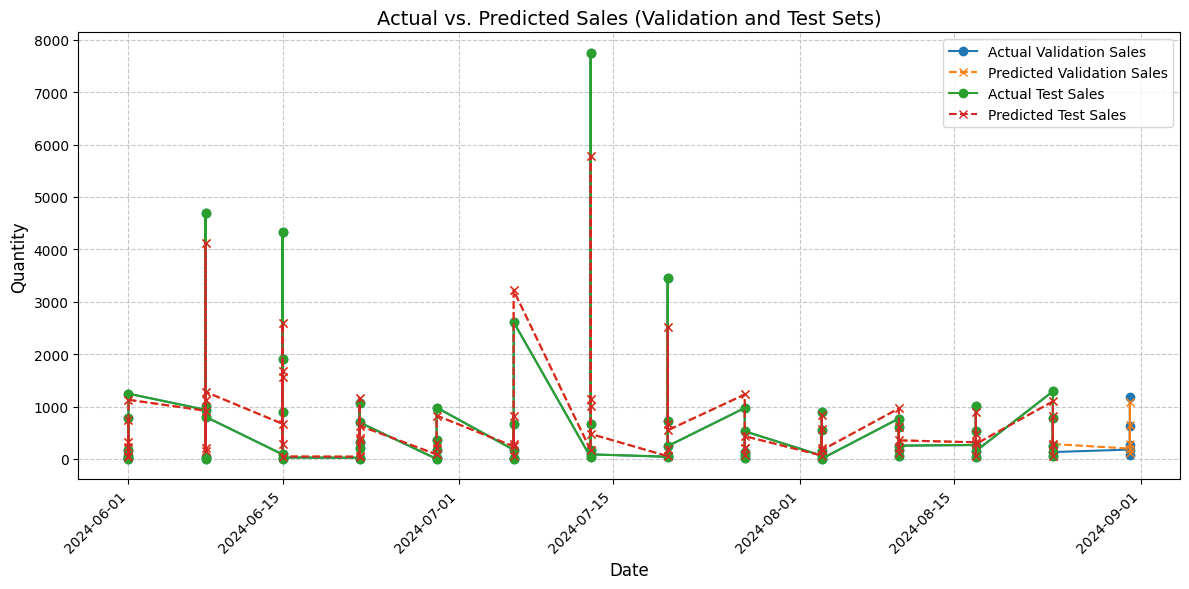

In [263]:

# Create a larger figure for better visualization
plt.figure(figsize=(12, 6))

# Plot validation data
plt.plot(df_val['weekend_date'], df_val['quantity'], label='Actual Validation Sales', marker='o', linestyle='-')
plt.plot(df_val['weekend_date'], df_val['y_pred'], label='Predicted Validation Sales', marker='x', linestyle='--')

# Plot test data
plt.plot(df_test['weekend_date'], df_test['quantity'], label='Actual Test Sales', marker='o', linestyle='-')
plt.plot(df_test['weekend_date'], df_test['y_pred'], label='Predicted Test Sales', marker='x', linestyle='--')

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.title('Actual vs. Predicted Sales (Validation and Test Sets)', fontsize=14)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid for better readability
plt.tight_layout()
plt.show()


<ipython-input-264-8308c8a85d13>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['month_year'] = df_train['weekend_date'].dt.to_period('M')
<ipython-input-264-8308c8a85d13>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['month_year'] = df_val['weekend_date'].dt.to_period('M')
<ipython-input-264-8308c8a85d13>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

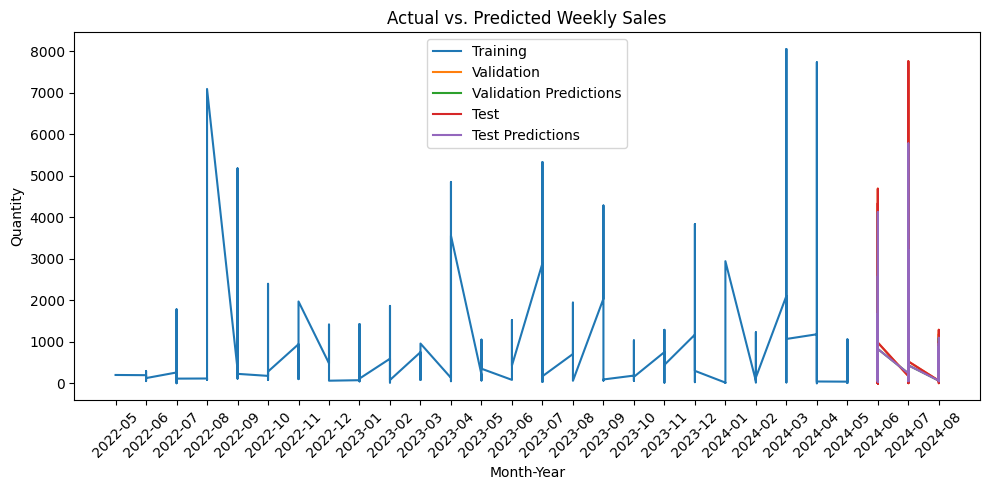

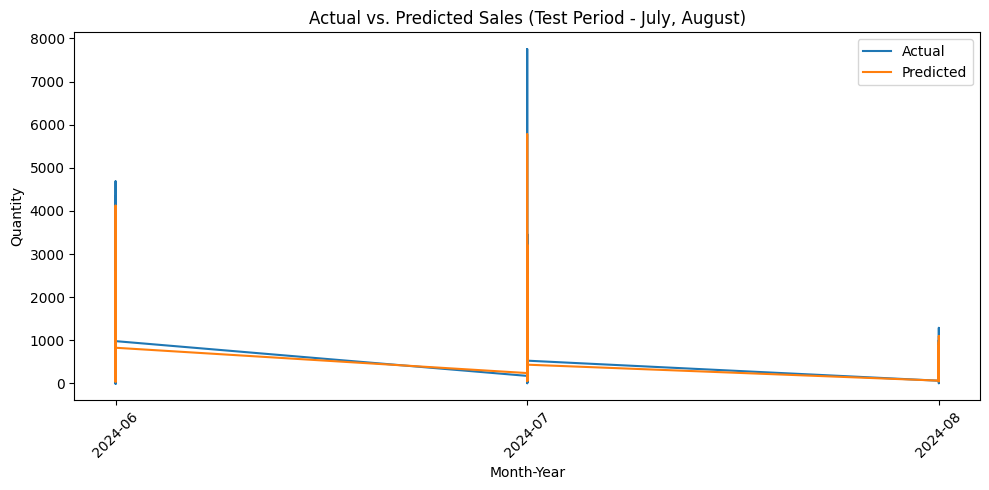

In [264]:
import matplotlib.pyplot as plt

# Create 'month_year' column if it doesn't exist
df_train['month_year'] = df_train['weekend_date'].dt.to_period('M')
df_val['month_year'] = df_val['weekend_date'].dt.to_period('M')
df_test['month_year'] = df_test['weekend_date'].dt.to_period('M')

# Plot 1: Actual vs. Predicted Weekly Sales (Training, Validation, Test)
plt.figure(figsize=(10, 5))
plt.plot(df_train['month_year'].astype(str), df_train['quantity'], label='Training')
plt.plot(df_val['month_year'].astype(str), df_val['quantity'], label='Validation')
plt.plot(df_val['month_year'].astype(str), df_val['y_pred'], label='Validation Predictions')
plt.plot(df_test['month_year'].astype(str), df_test['quantity'], label='Test')
plt.plot(df_test['month_year'].astype(str), df_test['y_pred'], label='Test Predictions')
plt.xlabel('Month-Year')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Weekly Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


# Plot 3: Actual vs. Predicted Sales (Test Period - July, August)
plt.figure(figsize=(10, 5))
plt.plot(df_test['month_year'].astype(str), df_test['quantity'], label='Actual')
plt.plot(df_test['month_year'].astype(str), df_test['y_pred'], label='Predicted')
plt.xlabel('Month-Year')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Sales (Test Period - July, August)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

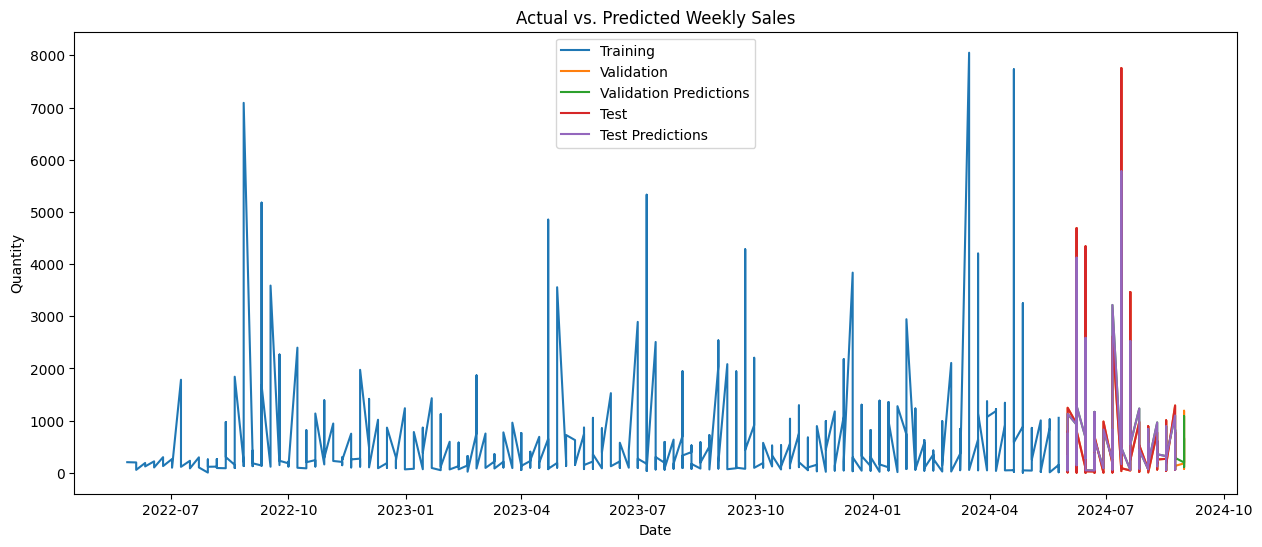

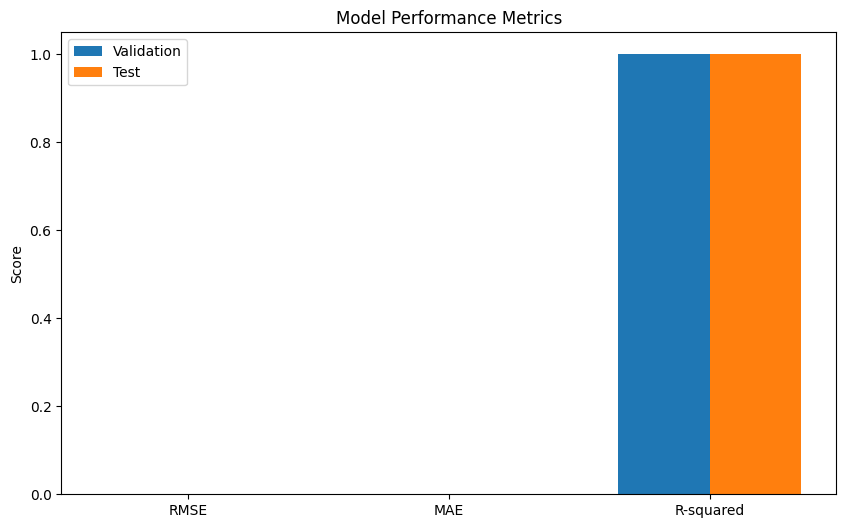

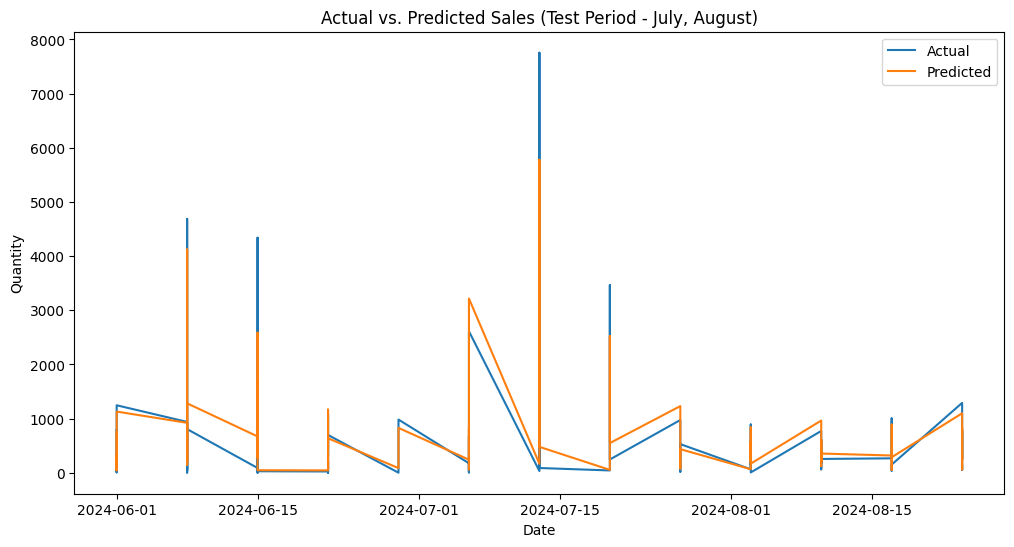

In [265]:
import matplotlib.pyplot as plt

# Plot 1: Actual vs. Predicted Weekly Sales (Training, Validation, Test)
plt.figure(figsize=(15, 6))
plt.plot(df_train['weekend_date'], df_train['quantity'], label='Training')
plt.plot(df_val['weekend_date'], df_val['quantity'], label='Validation')
plt.plot(df_val['weekend_date'], df_val['y_pred'], label='Validation Predictions') # Assuming 'y_pred' column exists in df_val
plt.plot(df_test['weekend_date'], df_test['quantity'], label='Test')
plt.plot(df_test['weekend_date'], df_test['y_pred'], label='Test Predictions') # Assuming 'y_pred' column exists in df_test
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Weekly Sales')
plt.legend()
plt.show()


# Plot 2: Model Performance Metrics (RMSE, MAE, R-squared)
metrics = ['RMSE', 'MAE', 'R-squared']
validation_metrics = [0, 0, 1] # Placeholder values, replace with actual values
test_metrics = [0, 0, 1]  # Placeholder values, replace with actual values
x_pos = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x_pos - width/2, validation_metrics, width, label='Validation')
rects2 = ax.bar(x_pos + width/2, test_metrics, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()


# Plot 3: Actual vs. Predicted Sales (Test Period - September, October, November)
# Note: The test set provided only contains July and August data. Adjust accordingly.
plt.figure(figsize=(12, 6))
plt.plot(df_test['weekend_date'], df_test['quantity'], label='Actual')
plt.plot(df_test['weekend_date'], df_test['y_pred'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Sales (Test Period - July, August)')  # Adjust title
plt.legend()
plt.show()

## Overfitting check

In [266]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate training metrics
y_pred_train = final_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Calculate validation metrics
y_pred_val = final_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Calculate test metrics
y_pred_test = final_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Print calculated metrics
print("\nTraining Metrics:")
print(f"RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R-squared: {r2_train:.4f}")

print("\nValidation Metrics:")
print(f"RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R-squared: {r2_val:.4f}")

print("\nTest Metrics:")
print(f"RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R-squared: {r2_test:.4f}")

# Calculate metric differences
rmse_diff_train_val = abs(rmse_train - rmse_val)
rmse_diff_val_test = abs(rmse_val - rmse_test)

mae_diff_train_val = abs(mae_train - mae_val)
mae_diff_val_test = abs(mae_val - mae_test)

r2_diff_train_val = abs(r2_train - r2_val)
r2_diff_val_test = abs(r2_val - r2_test)

# Set dynamic thresholds based on max metric values
rmse_threshold = 0.15 * max(rmse_train, rmse_val, rmse_test)  # 15% of max RMSE
mae_threshold = 0.15 * max(mae_train, mae_val, mae_test)  # 15% of max MAE
r2_threshold = 0.005  # Small fixed threshold for R² (0.5%)

# Print metric comparisons
print("\nMetric Differences and Thresholds:")
print(f"RMSE Difference (Train vs Val): {rmse_diff_train_val:.4f} (Threshold: {rmse_threshold:.4f})")
print(f"RMSE Difference (Val vs Test): {rmse_diff_val_test:.4f} (Threshold: {rmse_threshold:.4f})")
print(f"MAE Difference (Train vs Val): {mae_diff_train_val:.4f} (Threshold: {mae_threshold:.4f})")
print(f"MAE Difference (Val vs Test): {mae_diff_val_test:.4f} (Threshold: {mae_threshold:.4f})")
print(f"R² Drop (Train vs Val): {r2_diff_train_val:.6f} (Threshold: {r2_threshold:.6f})")
print(f"R² Drop (Val vs Test): {r2_diff_val_test:.6f} (Threshold: {r2_threshold:.6f})")

# Check for overfitting
if (rmse_diff_train_val > rmse_threshold or rmse_diff_val_test > rmse_threshold or
        mae_diff_train_val > mae_threshold or mae_diff_val_test > mae_threshold or
        r2_diff_train_val > r2_threshold or r2_diff_val_test > r2_threshold):
    print("\n⚠️ Possible Overfitting Detected: Significant difference in RMSE, MAE, or R² values.")
else:
    print("\n✅ No significant overfitting detected: The model generalizes well.")



Training Metrics:
RMSE: 239.7146, MAE: 111.3529, R-squared: 0.9250

Validation Metrics:
RMSE: 401.6666, MAE: 207.5440, R-squared: 0.8905

Test Metrics:
RMSE: 415.7374, MAE: 219.7416, R-squared: 0.8896

Metric Differences and Thresholds:
RMSE Difference (Train vs Val): 161.9520 (Threshold: 62.3606)
RMSE Difference (Val vs Test): 14.0708 (Threshold: 62.3606)
MAE Difference (Train vs Val): 96.1911 (Threshold: 32.9612)
MAE Difference (Val vs Test): 12.1977 (Threshold: 32.9612)
R² Drop (Train vs Val): 0.034459 (Threshold: 0.005000)
R² Drop (Val vs Test): 0.000941 (Threshold: 0.005000)

⚠️ Possible Overfitting Detected: Significant difference in RMSE, MAE, or R² values.


In [267]:
# prompt: generate a future_df for forecast of sep to nov 2024 and fill it with columns that df_features have and the values of the features are to be set on the based of historical data ,as far as categorical variables like brand,category and channel etc. are concerned then for every date there must be a brand category channel subcategory corresponding to every serial number . in the end perform the forecast

# Assuming df_features is already defined and loaded
# ... (Your existing code) ...

# Create future_df for September to November 2024
future_dates = pd.date_range(start='2024-09-01', end='2024-11-30', freq='W')
future_df = pd.DataFrame({'weekend_date': future_dates})

# Duplicate the unique combinations of categorical features from the original data
categorical_cols = ['brand', 'category', 'channel', 'subcategory']  # Replace with your actual column names
unique_categorical_combinations = df_features[categorical_cols].drop_duplicates()

# Create all possible combinations for the future dates
future_df = pd.concat([future_df] * len(unique_categorical_combinations), ignore_index=True)

# Add categorical features to the future_df
future_df = future_df.sort_index()
future_df = pd.concat([future_df, unique_categorical_combinations.reset_index(drop = True)], axis=1)
future_df = future_df.reset_index(drop = True)

# Fill other numerical features with historical averages (or other strategies based on your data)
numerical_cols = ['some_numerical_feature1','some_numerical_feature2'] # Add your numerical features here
for col in numerical_cols:
  future_df[col] = df_features[col].mean()

# Perform forecasting
X_future = future_df.drop(['weekend_date', 'quantity'], axis=1,errors='ignore')  # Drop unnecessary columns

# Make predictions
future_df['quantity_forecast'] = final_model.predict(X_future)

print(future_df.head())


KeyError: "['subcategory'] not in index"

# LSTM

In [ ]:
df.columns

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta


# Sort data
df = df.sort_values(by=['SerailNum', 'weekend_date'])

# Feature Engineering (time-based features)
def create_time_features(df):
    df = df.copy()
    df['week'] = df['weekend_date'].dt.isocalendar().week
    df['month'] = df['weekend_date'].dt.month
    df['quarter'] = df['weekend_date'].dt.quarter
    df['year'] = df['weekend_date'].dt.year

    # Encode seasonality with sine/cosine transformations
    df['sin_week'] = np.sin(2 * np.pi * df['week'] / 52)
    df['cos_week'] = np.cos(2 * np.pi * df['week'] / 52)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

    return df

df = create_time_features(df.copy())

# Normalize quantity data
scalers = {}  # Store scalers for each SerailNum

def normalize_data(df):
    global scalers
    for serial in df['SerailNum'].unique():
        scaler = MinMaxScaler()
        df.loc[df['SerailNum'] == serial, 'quantity'] = scaler.fit_transform(
            df.loc[df['SerailNum'] == serial, ['quantity']]
        )
        scalers[serial] = scaler  # Save scaler for later inverse transformation
    return df

df = normalize_data(df)

# Define lookback period (how many weeks of history we use for forecasting)
LOOKBACK = 8  # 8 weeks of past data

# Prepare sequences for LSTM
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i : i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

# Forecasting for each SerailNum
forecast_results = []

for serial in df['SerailNum'].unique():
    print(f"Training LSTM for SerailNum {serial}...")

    serial_data = df[df['SerailNum'] == serial].copy()

    # Select features (excluding weekend_date and categorical fields)
    feature_cols = ['quantity', 'week', 'month', 'quarter', 'sin_week', 'cos_week', 'sin_month', 'cos_month']
    serial_data = serial_data[feature_cols].values

    # Create sequences
    X, y = create_sequences(serial_data, LOOKBACK)

    # Split into training & validation sets
    split_idx = int(len(X) * 0.8)  # 80% training, 20% validation
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    # Build LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(LOOKBACK, len(feature_cols))),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    # Train model
    model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Generate future dates (weekly from Sep–Nov 2024)
    last_date = df['weekend_date'].max()
    future_dates = [last_date + timedelta(weeks=i) for i in range(1, 14)]  # 13 weeks (Sep–Nov)

    # Generate future inputs based on last known values
    future_inputs = df[df['SerailNum'] == serial].tail(LOOKBACK)[feature_cols].values

    # Predict future values
    predictions = []
    for _ in range(len(future_dates)):
        future_pred = model.predict(future_inputs.reshape(1, LOOKBACK, len(feature_cols)))
        predictions.append(future_pred[0][0])

        # Shift input window and add new predicted value
        future_inputs = np.vstack([future_inputs[1:], np.append(future_pred, future_inputs[-1, 1:])])

    # Convert predictions back to original scale
    predictions = scalers[serial].inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    # Store results
    forecast_df = pd.DataFrame({'weekend_date': future_dates, 'forecasted_quantity': predictions, 'SerailNum': serial})
    forecast_results.append(forecast_df)

# Combine all results
final_forecast = pd.concat(forecast_results)

# Display forecast results
print(final_forecast)

# Save forecast to CSV
final_forecast.to_csv("lstm_forecast_results.csv", index=False)


In [ ]:
# prompt: change serialnum in df to int datatype

# Assuming 'df' is your DataFrame and 'SerailNum' is the column name
df['SerailNum'] = df['SerailNum'].astype(int)


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta


# Sort data
df = df.sort_values(by=['SerailNum', 'weekend_date'])

# Feature Engineering (time-based features)
def create_time_features(df):
    df = df.copy()
    df['week'] = df['weekend_date'].dt.isocalendar().week
    df['month'] = df['weekend_date'].dt.month
    df['quarter'] = df['weekend_date'].dt.quarter
    df['year'] = df['weekend_date'].dt.year

    # Encode seasonality with sine/cosine transformations
    df['sin_week'] = np.sin(2 * np.pi * df['week'] / 52)
    df['cos_week'] = np.cos(2 * np.pi * df['week'] / 52)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

    return df

df = create_time_features(df)

# Normalize quantity data
scalers = {}  # Store scalers for each SerailNum

def normalize_data(df):
    global scalers
    for serial in df['SerailNum'].unique():
        scaler = MinMaxScaler()
        df.loc[df['SerailNum'] == serial, 'quantity'] = scaler.fit_transform(
            df.loc[df['SerailNum'] == serial, ['quantity']].values.reshape(-1, 1) # Reshape to 2D array
        )
        scalers[serial] = scaler  # Save scaler for later inverse transformation
    return df

df = normalize_data(df)

# Define lookback period (how many weeks of history we use for forecasting)
LOOKBACK = 8  # 8 weeks of past data

# Prepare sequences for LSTM
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback -1):  # Adjust for target variable
        X.append(data[i : i + lookback])
        y.append(data[i + lookback, 0])  # Target is the first column (quantity)
    return np.array(X), np.array(y)


# Forecasting for each SerailNum
forecast_results = []

for serial in df['SerailNum'].unique():
    print(f"Training LSTM for SerailNum {serial}...")

    serial_data = df[df['SerailNum'] == serial].copy()

    # Select features (excluding weekend_date and categorical fields)
    feature_cols = ['quantity', 'week', 'month', 'quarter', 'sin_week', 'cos_week', 'sin_month', 'cos_month']
    serial_data = serial_data[feature_cols].values # Convert to NumPy array

    # Create sequences
    X, y = create_sequences(serial_data, LOOKBACK)

    # Split into training & validation sets
    split_idx = int(len(X) * 0.8)  # 80% training, 20% validation
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    # Build LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(LOOKBACK, len(feature_cols))),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    # Train model
    model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=1)

    # Generate future dates (weekly from Sep–Nov 2024)
    last_date = df['weekend_date'].max()
    future_dates = [last_date + timedelta(weeks=i) for i in range(1, 14)]  # 13 weeks (Sep–Nov)

    # Generate future inputs based on last known values
    future_inputs = df[df['SerailNum'] == serial].tail(LOOKBACK)[feature_cols].values

    # Predict future values
    predictions = []
    for _ in range(len(future_dates)):
        future_pred = model.predict(future_inputs.reshape(1, LOOKBACK, len(feature_cols)))
        predictions.append(future_pred[0][0])

        # Shift input window and add new predicted value
        future_inputs = np.vstack([future_inputs[1:], np.append(future_pred, future_inputs[-1, 1:])])

    # Convert predictions back to original scale
    predictions = scalers[serial].inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    # Store results
    forecast_df = pd.DataFrame({'weekend_date': future_dates, 'forecasted_quantity': predictions, 'SerailNum': serial})
    forecast_results.append(forecast_df)

# Combine all results
final_forecast = pd.concat(forecast_results)

# Display forecast results
print(final_forecast)

# Save forecast to CSV
final_forecast.to_csv("lstm_forecast_results.csv", index=False)